In [1]:
import numpy as np

import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy import signal as sig
import ipywidgets as widgets
from IPython.display import display

import galois
from pn_lfsr import pnsequence,zdcsequence


In [2]:
h = []
for i in range(16):
    h.append(widgets.FloatSlider(
        value=0,
        min=-1.0,
        max=1.0,
        step=0.1,
        description='h_'+str(i)+':',
        disabled=False,
        continuous_update=False,
        orientation='vertical',
        readout=True,
        readout_format='.1f',))


# Tapped Delay Model:



+ In a wireless communication system, a signal can propagate along different physical path from the source to the sink
+ In the Tapped Delay Model different physical path with approximately the same propagation time are combined in one tap of the impulse response, leading to an FIR-like channel
+ As the environment changes with time, physical path can belong to different tap as time goes on.

$\rightarrow$ Tapped Delay Model is represented by an impulse response with possibly complex tap values


### Zeropadding: Adding of M zeros
$$y_n'=\begin{cases}y_n \quad \text{für } 0 \leq n \leq N-1 \\0 \quad \text{für }  N\leq n \leq N+m-1\end{cases}$$

This results in:

$$Y[k]'=\sum_{n=0}^{N+M-1}y[n]'\cdot \exp \left(-j2\pi\cdot \frac{kn}{N+M}\right )=\sum_{n=0}^{N-1}y[n]'\cdot \exp \left(-j2\pi\cdot \frac{kn}{N+M}\right), \quad \text{für } k=0,\dots, N+M-1$$

Due to the adding of zeros between the sampling points and the constant sampling frequency, the observation time increases. Therefore, the frequency resolution becomes finer. This can be seen from the new frequency index:
$$ k'=k\cdot \frac{N}{N+M}.$$ 

It is important to mention, that only the represantation for our human eyes becomes better. The envelope is unchanged by zeropadding. There is no information gain by adding zeros.

In [3]:
impulse_response = np.zeros(16)

In [4]:
def kanalimpulsantwort(h_0, h_1, h_2, h_3, h_4, h_5, h_6, h_7,
                       h_8, h_9, h_10, h_11, h_12, h_13, h_14, h_15):

    x = np.array([h_0, h_1, h_2, h_3, h_4, h_5, h_6, h_7,
                  h_8, h_9, h_10, h_11, h_12, h_13, h_14, h_15])

    impulse_response = np.copy( x )
    X = np.fft.fft(x, n=128)  # n=128 for zero padding // Here we use the fft from numpy. An own DFT implementation can be seen in Fourier_Transform.ipynb

    fig, ax = plt.subplots(2, 3, figsize=(20, 7.5))

    markerline, stemlines, baseline = ax[0][0].stem(
        np.arange(len(x))-len(x)/2, x)  # Verschiebung um N/2
    plt.setp(stemlines, 'color', plt.getp(markerline, 'color'))
    plt.setp(stemlines, 'linestyle', 'dotted')

    # Akausal
    ax[0][0].set_ylim(-1.1, 1.1)
    ax[0][0].set_title('Impulsantwort akausal')
    ax[0][1].plot((2*np.arange(X.size)/(X.size)-1) *
                  np.pi, np.abs(np.fft.fftshift(X)))
    ax[0][1].set_title('Amplitudengang akausales Signal')

    ax[0][2].plot((2*np.arange(X.size)/(X.size)-1) *
                  np.pi, np.angle(-1*np.fft.fftshift(X)))  # Verschiebung um N/2 entspricht einer Multiplikation des Frequenzgangs mit exp(-j*pi)=-1
    ax[0][2].set_title('Phasengang akausales Signal')

    markerline, stemlines, baseline = ax[1][0].stem(np.arange(len(x)), x)
    plt.setp(stemlines, 'color', plt.getp(markerline, 'color'))
    plt.setp(stemlines, 'linestyle', 'dotted')

    # Kausal
    ax[1][0].set_ylim(-1.1, 1.1)
    ax[1][0].set_title('Impulsantwort kausal')
    ax[1][1].plot((2*np.arange(X.size)/(X.size)-1) *
                  np.pi, np.abs(np.fft.fftshift(X)))
    ax[1][1].set_title('Amplitudengang kausales Signal')
    ax[1][2].plot((2*np.arange(X.size)/(X.size)-1) *
                  np.pi, np.angle(np.fft.fftshift(X)))
    ax[1][2].set_title('Phasengang kausales Signal')

    # print(np.sum(x))
    return impulse_response


+ In the following (interactive) illustration, the coefficients of an impulse response of length N=16 can be chosen. 
+ The resulting frequency response of a causal and acausal version are plotted. The magnitude are the same, whereas the phase differs. This follows directly from the following property of the fourier transform:
$$\mathcal{F}(x(t-t_0))=\exp (-j2\pi f t_0)\cdot X(f) $$

+ **Note:** As a simplification, we restrict ourself to real valued impulse responses.

In [5]:
ui = widgets.HBox( h )

out = widgets.interactive_output( kanalimpulsantwort, {'h_0': h[0], 'h_1': h[1], 'h_2': h[2], 'h_3': h[3], 'h_4': h[4], 'h_5': h[5], 'h_6': h[6],
                                 'h_7': h[7], 'h_8': h[8], 'h_9': h[9], 'h_10': h[10], 'h_11': h[11], 'h_12': h[12], 'h_13': h[13], 'h_14': h[14], 'h_15': h[15]})


display(ui, out)


Output()

# Estimation of Impulse Response 

+ In a next step, we want to estimate the impulse response of a channel. 
+ We use PN and Zadoff-Chu sequences because their ACF has some appealing properties

In [6]:
# init GF_2 object
GF_2 = galois.GF(2)


## Some Sequences

### m-Sequence

+ Own implementation of a Pseudonoise (PN) sequence. 
+ It can easily be generated using two Linear Feedback Shift Registers (LFSR).
+ **Note:** The according library has to be available in the current directory and should be imported (see first cell) 

<StemContainer object of 3 artists>

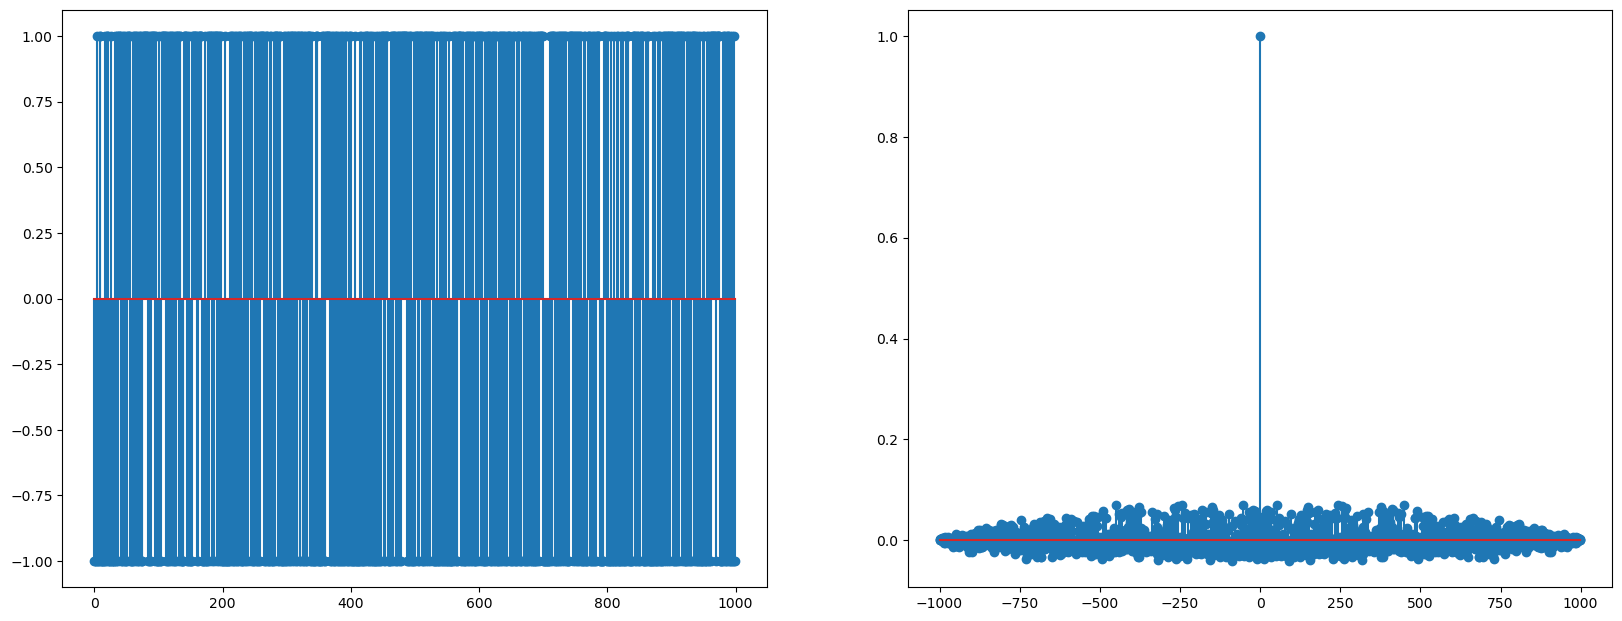

In [7]:

sequence_length=int(1e3)
order = 12
primitive_polynomial = galois.matlab_primitive_poly(2, degree=order) #According documentation supported up to an order of 16

seed = GF_2.Zeros(order)
seed[-1] = 1  # seed [0,0..,0,1]--> must be non zero array!

pn = pnsequence(prim_poly=primitive_polynomial, seed=seed, sequence_length=sequence_length)

#BPSK modulation
pn_mod = 1-2 * pn

acf_pn = np.correlate( pn_mod, pn_mod, 'full')
acf_pn = acf_pn / len( pn_mod ) 

fig, ax = plt.subplots(1, 2, figsize=(20, 7.5))
ax[0].stem(np.arange(0, len( pn_mod ), 1), pn_mod )
ax[1].stem(np.arange( - ( len( pn ) - 1), len( pn ) ), acf_pn )


### Zadoff-Chu-Sequence 

+ Those are used in some standards, e.g., in 4G for synchronization. 
+ The ACF also is close to the Kronecker delta function. 
+ The benefit of the ZC sequence is that is has a constant amplitude, thus it has lower demands on the linearity of amplifiers.

True


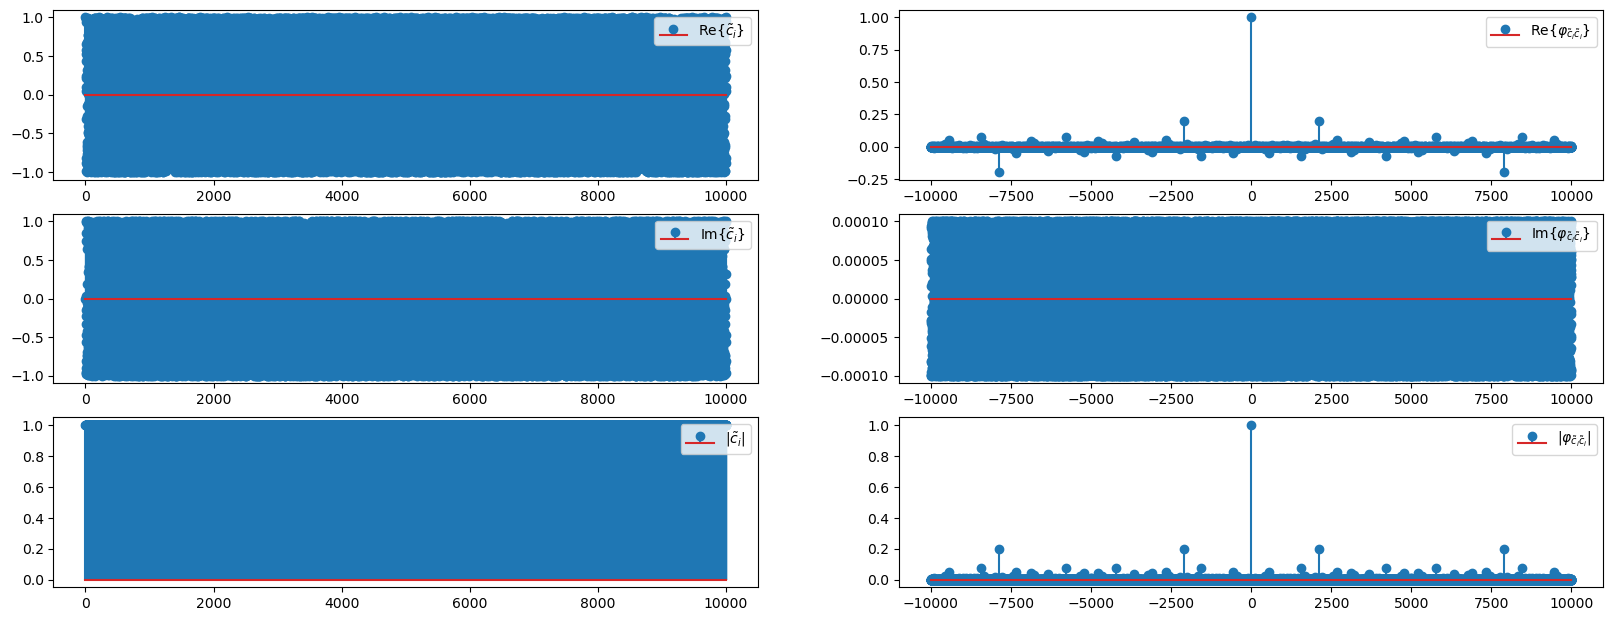

In [8]:
#Sequence length and M must be coprime!
# Can be tested with galois
sequence_length=10000

M=1009 #beneficial if prime number

print( galois.are_coprime( sequence_length, M ) )
zdc = zdcsequence( sequence_length, M )

# get acf of Zadoff-Chu
acf_zdc = np.correlate( zdc, zdc,'full')
acf_zdc = acf_zdc / len( zdc ) 


fig,ax = plt.subplots(3,2,figsize=(20,7.5))

ax[0][0].stem( np.arange( 0,len(zdc), 1), np.real( zdc ), label='Re$\{\\tilde{c}_i\}$' )
ax[0][0].legend(loc=1)

ax[0][1].stem( np.arange( -( len (zdc) - 1) , len( zdc ) ), np.real( acf_zdc ), label='Re$\{\\varphi_{\\tilde{c}_i\\tilde{c}_i}\}$' )
ax[0][1].legend(loc=1)

ax[1][0].stem( np.arange( 0,len(zdc), 1), np.imag( zdc ), label='Im$\{\\tilde{c}_i\}$')
ax[1][0].legend(loc=1)

ax[1][1].stem( np.arange( -( len (zdc) - 1) , len( zdc ) ), np.imag( acf_zdc ), label='Im$\{\\varphi_{\\tilde{c}_i\\tilde{c}_i}\}$' )
ax[1][1].legend(loc=1)

ax[2][0].stem( np.arange( 0,len(zdc), 1), np.abs( zdc ), label='$|\\tilde{c}_i|$' )
ax[2][0].legend(loc=1)

ax[2][1].stem( np.arange( -( len (zdc) - 1) , len( zdc ) ), np.abs( acf_zdc ), label='$|\\varphi_{\\tilde{c}_i\\tilde{c}_i}|$' )
ax[2][1].legend(loc=1)



**Comments:**

+ In the lower left plot, one can see that the amplitude is constant!


### PN sequence generated with the numpy toolbox

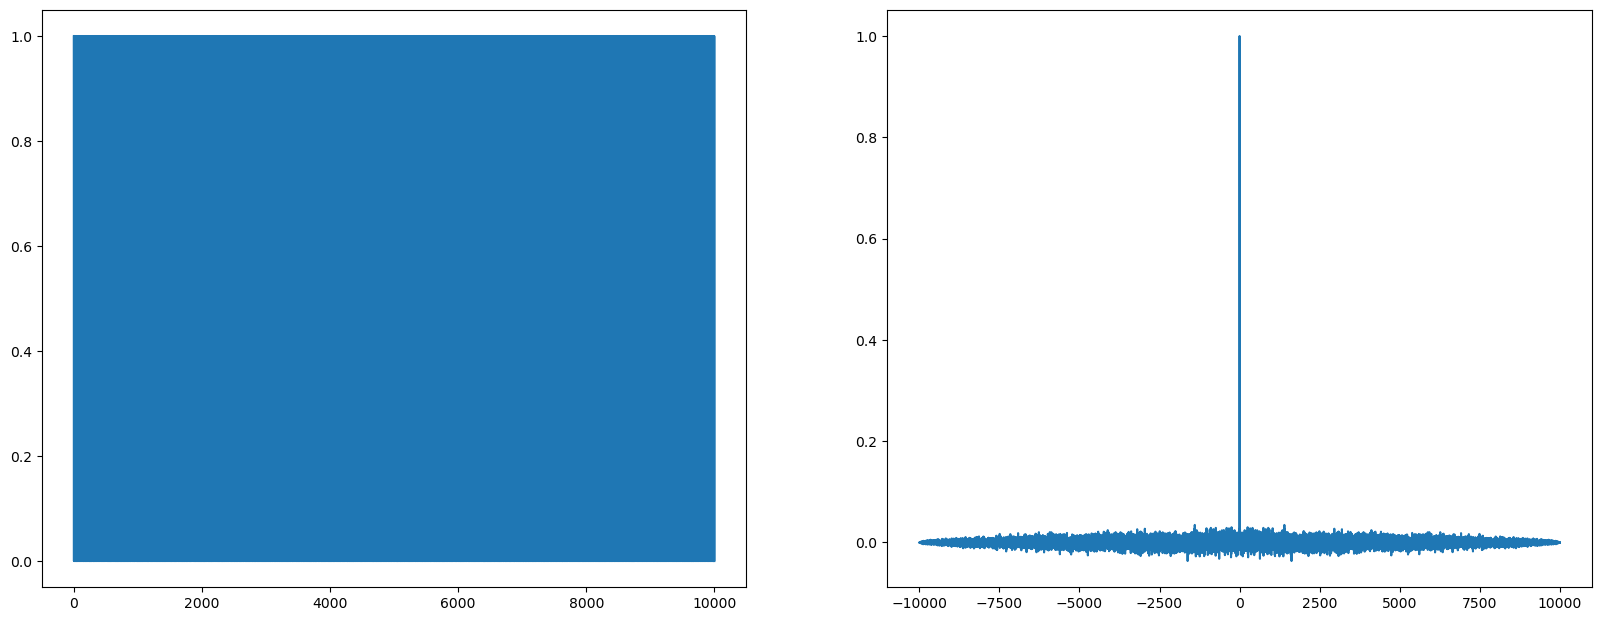

In [9]:
pn_np = np.random.randint( 0, 2, 10000 )

pn_np_mod = 1 - 2 * pn_np

acf_pn_np = np.correlate( pn_np_mod, pn_np_mod, 'full')
acf_pn_np = acf_pn_np / len( pn_np )

fig,ax=plt.subplots(1,2,figsize=(20,7.5))
ax[0].plot(np.arange(0,len(pn_np),1), pn_np )
ax[1].plot(np.arange( -( len( pn_np) - 1), len( pn_np ) ), acf_pn_np )

## Now Channel Estimation

### Define an impulse response to be estimated

In [10]:
impulse_response = np.array(    [0, 0, 0, 0, 0.5, 0.5, 1, 1, 1, 0.5, 0.5, 0, 0, 0, 0, 0])

sequence_length=1e3

sequence_type='zcsequence' # OR 'nprandom' OR 'pnsequence' OR 'zcsequence'

if ( sequence_type=='zcsequence' ):
    sequence = zdcsequence(sequence_length, M)

elif ( sequence_type=='nprandom'):
    sequence = np.random.randint( 0, 2, int(sequence_length) )
    sequence = 1 - 2 * sequence

else:
    order = 12
    primitive_polynomial = galois.matlab_primitive_poly(2, degree=order) #According documentation supported up to an order of 16

    seed = GF_2.Zeros(order)
    seed[-1] = 1  # seed [0,0..,0,1]--> must be non zero array!

    sequence = pnsequence(prim_poly=primitive_polynomial, seed=seed, sequence_length=int(sequence_length))
    sequence = 1 - 2 * sequence


### Estimation - Option 1
+ Now we transmit the known sequence $p[n]$ over the channel with impulse response $h[n]$:
$$y[n]=(p*h)[n] \iff Y[k]=P[k]\cdot H[k]$$
+ One possible way to estimate the impulse response of the channel is to calculate its frequency response:
$$H[k]=\frac{Y[k]}{P[k]}$$
+ Then perform inverse Fourier transform
+ Suppose we know the lenght of the impulse response, e.g. $N=16$, then we can extract it:

In [11]:
received = np.convolve( sequence, impulse_response, mode='full')

print('Length of received sequence', len( received ) )

fft_length=int(np.log2(len(received)))+2 #+1 should also suffice

estimate_ft = np.fft.fft(received,int(2**fft_length))/np.fft.fft(sequence,int(2**fft_length))
estimate = np.fft.ifft(estimate_ft)
estimate = np.where(estimate<1e-10,0,estimate)
print( 'Estimated sequence:', np.abs(estimate[0:16]))


Length of received sequence 1015
Estimated sequence: [0.  0.  0.  0.  0.5 0.5 1.  1.  1.  0.5 0.5 0.  0.  0.  0.  0. ]


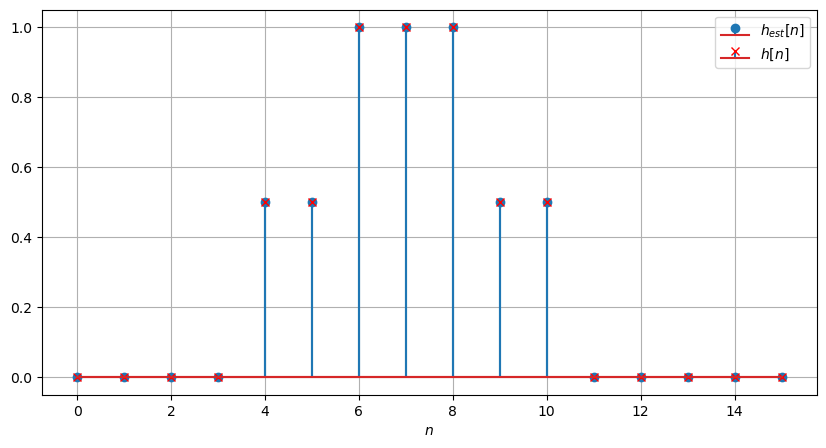

In [12]:
fig=plt.figure(figsize=(10,5))
plt.stem( np.abs(estimate[0:16]), label='$h_{est}[n]$')

plt.stem( impulse_response, markerfmt='rx', label='$h[n]$')

plt.xlabel('$n$')
plt.legend( loc='upper right')
plt.grid(1)

### Estimation - Option 2 

+ Now we use an approach based on cross-correlation:
$$y[n]=(p*h)[n]=\sum_{m=-\infty}^{\infty} p[m]\cdot h[n-m]$$

+ The sequences are chosen according to:
$$r_{pp}[k]=\sum_{n=-\infty}^{\infty}p[n+k]\cdot p^*[n]=a\cdot\delta[k]$$

+ Thus we can use the cross-correlation of the received sequence with the know pseudo noise sequence to estimate the channel impulse response:
$$r_{yp}[k]=y[k]*p^*[-k]=p[k]*h[k]*p^*[-k]=h[k]*p[k]*p^*[-k]=h[k]*a\cdot \delta[k]=a\cdot h[k]$$



**Note:**
+ It is important to be careful with np.convolve and np.correlate. Both have some different operating modes (mode = 'valid', 'same', 'full').
+ In our case we want for both the default setting (np.convolve uses full whereas np.correlate uses valid).
+ We need the mode='full' for the convolution, because the boundary effects are important to get the information of the impulse response.


In [13]:
estimate_correlation = np.correlate( received, sequence) #,mode="same") #unten[500:530]
#temp_est = np.where( temp_est < 1.5e-1, 0 , temp_est)

estimate_correlation = estimate_correlation / estimate_correlation.max()

print('Estimated correlation: ', estimate_correlation ) # h[k]=r_yp[k]/a

Estimated correlation:  [-0.00300873-0.00051049j  0.0033771 +0.0005772j  -0.00342017-0.00056194j
  0.00313555+0.00048627j  0.49594486-0.00038374j  0.50133673+0.00025841j
  0.99511336-0.00013459j  1.        +0.j          0.99511336+0.00013459j
  0.50133673-0.00025841j  0.49594486+0.00038374j  0.00313555-0.00048627j
 -0.00342017+0.00056194j  0.0033771 -0.0005772j  -0.00300873+0.00051049j
  0.00240014-0.00036906j]


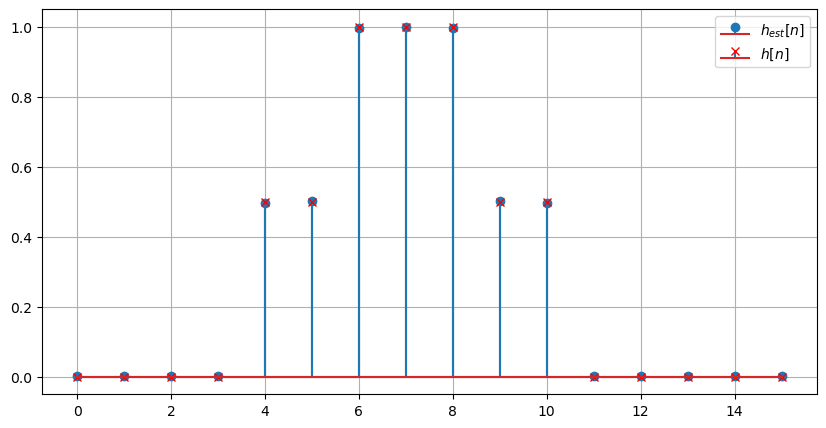

In [14]:
fig=plt.figure(figsize=(10,5))
plt.stem( np.abs( estimate_correlation ), label='$h_{est}[n]$' )
plt.stem( impulse_response,markerfmt = 'rx', label='$h[n]$' )

plt.grid(1)
plt.legend( loc='upper right')

## Final Comments

+ We can see, that in both cases the impulse response can almost be recoverd. 
+ Since the ACF differs from a perfect Kronecker delta function, the impulse response is not perfectly estimated